# Assignment 11: Phân loại phương tiện giao thông

Tổng quan: Ở bài tập này chúng ta sẽ lần lượt thực hành các bước để xây dựng một hệ thống học máy cho bài toán phân loại phương tiện giao thông: khảo sát dữ liệu, trích xuất đặc trưng, xây dựng mô hình phân loại, phân loại trên hình ảnh thực tế. Bài tập yêu cầu các kiến thức về lập trình Python với các thư viện: OpenCV, scikit-learn, pickle, numpy.

In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## Câu hỏi 1: Khảo sát tập dữ liệu
Bộ dữ liệu được lưu ở thư mục con trainingset trong thư mục bài tập này. Thư mục trainingset bao gồm 5 thư mục con ứng với 5 nhãn của bài toán, trong mỗi thư mục con chứa ảnh tương ứng với nhãn. Với câu hỏi đầu tiên này chúng ta sẽ khảo sát những đặc điểm của bộ dữ liệu, hãy lập trình hoàn chỉnh các hàm theo các yêu cầu cụ thể sau đây:

### Câu hỏi 1.1: Quan sát một vài mẫu dữ liệu
Trước tiên ta sẽ quan sát một vài ví dụ về bộ dữ liệu. Hãy lập trình hàm load_image() nhận đầu vào là đường dẫn ảnh, trả về mảng numpy lưu trữ ảnh, sử dụng thư viện OpenCV. Câu hỏi này giúp bạn ôn tập cách thức load ảnh với OpenCV và hướng dẫn bạn những thao tác cơ bản với thư viện os. Hãy quan sát đoạn mã nguồn dưới đây:

In [11]:
def load_image(image_path):
    #### YOUR CODE HERE ####

    return cv2.imread(image_path)

    #### END YOUR CODE #####

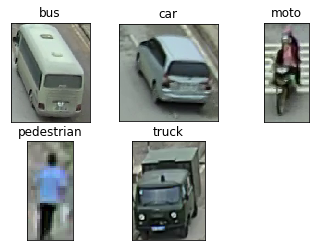

In [12]:
samples_list = []
samples_label = []
for label in os.listdir('trainingset'):
    sample_file = os.listdir(os.path.join('trainingset', label))[0]
    
    samples_list.append(load_image(os.path.join('trainingset', label, sample_file)))
    
    samples_label.append(label)
    
for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])
    
plt.show()

Một vài hàm hay sử dụng trong thư viện os:
- Hàm os.listdir(path): Trả về một list chứa tên các thư mục và file nằm trong thư mục path. Vì hàm trả về một list nên ta có thể tính được tổng số folder và file trong một thư mục (dùng hàm len())
- Hàm os.path.join(t1, t2, [t3, ...]): Trả về đường dẫn trong hệ điều hành tương ứng nối các đường dẫn t1, t2, t3,... Ví dụ ta có t1 = 'trainingset', t2 = 'image' thì hàm trả về xâu s = 'trainingset/image' với Ubuntu hoặc s = 'trainingset\\image' với Windows. 

### Câu hỏi 1.2: Thống kê dữ liệu
Hãy lập trình hàm statistic() để thống kê số lượng ảnh ứng với mỗi nhãn. Hàm statistic() cần trả về 2 danh sách (list): label, num_images. Danh sách label lưu tên các nhãn và danh sách num_images lưu số lượng ảnh tương ứng với nhãn lưu ở danh sách label.

In [13]:
def statistic():
    label = []
    num_images = []

    #### YOUR CODE HERE ####

    for lab in os.listdir('trainingset'):
        label.append(lab)
        num_images.append(len(os.listdir(os.path.join('trainingset', lab))))

    #### END YOUR CODE #####

    return label, num_images

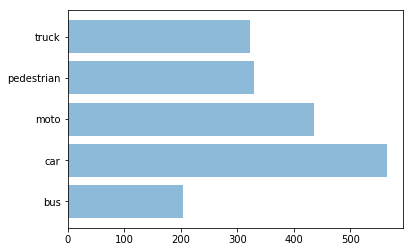

Total images: 1855


In [14]:
label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

### Câu hỏi 1.3: Xây dựng danh sách chứa ảnh

Để tiện cho việc lập trình các bước tiếp theo ta sẽ xây dựng một list lưu trữ ảnh và nhãn tương ứng của nó. Hãy lập trình hàm read_data(), hàm này trả về hai list X, Y, trong đó mỗi phần tử của list X lưu trữ một mảng numpy biểu diễn một ảnh và mỗi phần tử của list Y lưu trữ nhãn (dưới dạng số nguyên) tương ứng của ảnh.

In [15]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir('trainingset'):
        for img_file in os.listdir(os.path.join('trainingset', label)):
            #### YOUR CODE HERE ####
            img = load_image(os.path.join('trainingset', label, img_file))
            #### END YOUR CODE #####
            
            X.append(img)
            Y.append(label2id[label])
    return X, Y

In [16]:
# Label to id, used to convert string label to integer 
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
for i in range(10):
    print(X[i].shape)
print(Y[0])

1855
1855
(168, 134, 3)
(270, 193, 3)
(168, 120, 3)
(107, 83, 3)
(97, 80, 3)
(39, 34, 3)
(182, 139, 3)
(53, 35, 3)
(98, 66, 3)
(174, 119, 3)
4


## Câu hỏi 2: Trích xuất đặc trưng (features extraction)

Ở câu hỏi này chúng ta sẽ lần lượt thực hiện các công việc: trích xuất đặc trưng SIFT (SIFT keypoints descriptor), xây dựng từ điển và mô hình Bag-of-Word (BoW). Bạn hãy lập trình hoàn chỉnh các hàm theo yêu cầu cụ thể dưới đây

### Câu hỏi 2.1: Trích xuất đặc trưng SIFT

Hãy lập trình hàm extract_sift_features() nhận đầu vào là list ảnh ta đã xây dựng được từ câu hỏi trước và trả về list image_descriptors, phần tử thứ p trong list image_descriptors lại là một list chứa các SIFT keypoints descriptor ứng với ảnh thứ p trong list X.

Gợi ý: Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create(). Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. Chúng ta sẽ dùng các des này để phục vụ bài toán phân loại.

In [17]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()

    for i in range(len(X)):
        _, des = sift.detectAndCompute(X[i], None)
        #### YOUR CODE HERE ####
        image_descriptors.append(des)
        #### END YOUR CODE #####

    return image_descriptors

In [18]:
image_descriptors = extract_sift_features(X)
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1855
<type 'numpy.ndarray'>
Image 0 has 109 descriptors
Image 1 has 148 descriptors
Image 2 has 59 descriptors
Image 3 has 29 descriptors
Image 4 has 83 descriptors
Image 5 has 28 descriptors
Image 6 has 219 descriptors
Image 7 has 22 descriptors
Image 8 has 62 descriptors
Image 9 has 181 descriptors


### Câu hỏi 2.2: Xây dựng từ điển
Hãy lập trình hàm kmeans_bow() nhận đầu vào là một list gồm tất cả các descriptors của các ảnh trong tập X và số cụm num_clusters, sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm. Hàm trả về một danh sách center của các cụm. Vì thao tác này mất rất nhiều thời gian nên ta sẽ lưu danh sách trả về bởi hàm kmeans_bow() ra một file nhị phân (sử dụng thư viện pickle) để tiện sử dụng sau này.

Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors:

In [19]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 171041


Hãy lập trình hàm kmeans_bow().

Gợi ý: Trong thư viện sklearn, để khởi tạo một đối tượng kmeans ta sử dụng lệnh:
kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)

Đối tượng kmeans có phương thức fit, nhận vào các điểm dữ liệu (trong bài toán hiện tại của chúng ta là list all_descriptors) và tìm ra n_clusters vector là tâm của các cụm dữ liệu. Để lấy được các vector này ta sử dụng thuộc tính $cluster_centers_$  của đối tượng kmeans

In [20]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    #### YOUR CODE HERE ####

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    #### END YOUR CODE #####

    return bow_dict

In [22]:
num_clusters = 50
if not os.path.isfile('bow_dictionary.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary.pkl', 'rb'))
    # BoW = pickle.load(open('bow_dictionary.pkl', 'rb'), encoding='latin1')
    
print(len(BoW))
print(type(BoW[0]))

50
<type 'numpy.ndarray'>


### Câu hỏi 2.3: Xây dựng vector đặc trưng với mô hình BoW

Hãy xây dựng hàm create_features_bow() nhận đầu vào là list image_descriptors, list BoW và num_clusters ở trên, trả về list X_features, trong đó phần tử thứ p của X_vectors là vector đặc trưng theo mô hình BoW ứng với ảnh thứ p, tập keypoint descriptors thứ p. Hãy chú ý sự tương ứng các phần tử trong 4 danh sách: X, Y, image_descriptors, X_features.

In [23]:
from scipy.spatial.distance import cdist

In [24]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            #### YOUR CODE HERE ####
            argmin = np.argmin(distance, axis=1)
            
            for j in argmin:
                features[j] += 1
            #### END YOUR CODE #####

        X_features.append(features)


    return X_features

In [26]:
print(image_descriptors[0].shape)
print(BoW[0].shape)
X_features = create_features_bow(image_descriptors, BoW, num_clusters)
print(len(X_features))
print(X_features[0])
print(sum(X_features[0]))
print(image_descriptors[0].shape[0])

(109, 128)
(128,)
1855
[ 1  0  1  0  1  1  6  1  5 10  2  1  1  3  5  2  2  0  1  4  1  2  4  2
  2  1  0  0  3  1  4  1  2  3  0  0  2  1  9  2  0  0  3  2  3  2  0  2
  5  5]
109
109


## Câu hỏi 3: Xây dựng mô hình
Từ các câu hỏi trước chúng ta đã xây dựng được vector đặc trưng ứng với mỗi ảnh trong bộ dữ liệu. Ở câu hỏi này chúng ta sẽ xây dựng các mô hình phân loại SVM

In [27]:
print(len(X_features))
print(len(Y))

1855
1855


Chia tập dữ liệu thành tập train/test:

In [29]:
from sklearn.model_selection import train_test_split

X_train = [] 
X_test = []
Y_train = []
Y_test = []
#### YOUR CODE HERE #### 
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)
#### END YOUR CODE ####
print(len(X_train))
print(len(X_test))

1484
371


Khai báo đối tượng SVM:

In [31]:
svm = sklearn.svm.SVC(C = 30)
print(svm)

SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Huấn luyện, kiểm tra độ chính xác của mô hình tương tự như các bài học trước (sử dụng các hàm fit, predict, score,... của đối tượng svm)

Huấn luyện mô hình:

In [33]:
svm.fit(X_train, Y_train)

SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Tính độ chính xác trên tập dữ liệu huấn luyện:

In [34]:
svm.score(X_train, Y_train)

1.0

Tính độ chính xác trên tập dữ liệu test:

In [35]:
svm.score(X_test, Y_test)

0.7412398921832885

## Câu hỏi 4: Dùng mô hình đã huấn luyện dự đoán hình ảnh thực tế

Cuối cùng ta sẽ dùng thử mô hình đã huấn luyện để đưa ra dự đoán về một hình ảnh thực tế. Chúng ta sẽ làm lần lượt các bước: đọc ảnh, trích xuất đặc trưng BoW của ảnh, dự đoán sử dụng mô hình đã huấn luyện.

__Bước 1__: Đọc ảnh ở đường dẫn image_test/car.png, lưu ảnh vào biến img

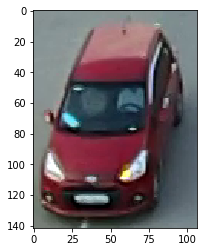

(142, 107, 3)


In [36]:
img = None

#### YOUR CODE HERE ####
img = load_image('image_test/car.png')
#### END YOUR CODE ####

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

print(img.shape)
my_X = [img]

__Bước 2__: Trích xuất đặc trưng SIFT (lưu vào biến my_image_descriptors) và BoW (lưu vào biến my_X_features) từ my_X:

In [37]:
my_image_descriptors = None
my_X_features = None

#### YOUR CODE HERE ####
my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)
#### END YOUR CODE #####

print(len(my_image_descriptors))
print(my_X_features[0].shape)

1
(50,)


__Bước 3:__ Sử dụng mô hình đã huấn luyện để dự đoán, kết quả dự đoán lưu vào biến my_y_pred

In [38]:
y_pred = None

#### YOUR CODE HERE ####
y_pred = svm.predict(my_X_features)
#### END YOUR CODE #####

print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
for key, value in label2id.items():
    if value == y_pred[0]:
        print('Your prediction: ', key)

[3]
{'bus': 4, 'pedestrian': 0, 'truck': 2, 'car': 3, 'moto': 1}
('Your prediction: ', 'car')


# BÀI TẬP VỀ NHÀ 

1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

2. Sử dụng thuật toán Grid search kết hợp với Cross Validation tìm tham số tốt nhất cho mô hình SVM.

3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Decision tree, Random forest. So sánh các kết quả và đưa ra nhận xét. 

4. Thử nghiệm bài toán Phân loại cảm xúc FERC-2013: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

In [ ]:
svm = SVC()
param = {'C': [0.5, 1, 5], 'kernel': ['poly', 'rbf', 'sigmoid']}

gs = GridSearchCV(estimator=svm, param_grid=param, cv=3, n_jobs=4)
print(gs)

gs.fit(x_train, y_train)
gs.score(x_test, y_test)